# Xopt Stopping Conditions Tutorial

This notebook demonstrates various stopping conditions available in Xopt. Stopping conditions allow you to automatically terminate optimization runs based on different criteria such as:

- Maximum number of evaluations
- Target value achievement  
- Convergence detection
- Stagnation detection
- Feasibility achievement
- Custom composite conditions

We'll explore each type with practical examples using both synthetic and real optimization problems.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

from xopt import Xopt, Evaluator, VOCS
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.generators.random import RandomGenerator
from xopt.stopping_conditions import (
    MaxEvaluationsCondition,
    TargetValueCondition,
    ConvergenceCondition,
    StagnationCondition,
    FeasibilityCondition,
    CompositeCondition,
)
from xopt.stopping_conditions import get_stopping_condition


# Ignore warnings for cleaner output
import warnings

warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


## Test Functions

Let's define some test functions to demonstrate the stopping conditions. We'll use:
1. **Sphere function** - Simple quadratic with known minimum at origin
2. **Noisy quadratic** - Similar to sphere but with noise to test convergence
3. **Constrained function** - Function with constraints to test feasibility stopping

In [2]:
# Define test functions


def sphere_function(inputs: dict):
    """Simple sphere function with minimum at origin"""
    x = np.array([inputs[f"x{i}"] for i in range(2)])
    return {"f": np.sum(x**2)}


def noisy_quadratic(inputs: dict):
    """Quadratic function with noise to test convergence detection"""
    x = np.array([inputs[f"x{i}"] for i in range(2)])
    noise = np.random.normal(0, 0.1)  # Add some noise
    return {"f": np.sum((x - 1) ** 2) + noise}


def constrained_function(inputs: dict):
    """Function with constraints to test feasibility stopping"""
    x1, x2 = inputs["x1"], inputs["x2"]

    # Objective: minimize distance from (0.5, 0.5)
    obj = (x1 - 0.5) ** 2 + (x2 - 0.5) ** 2

    # Constraints:
    # c1: x1^2 + x2^2 >= 0.25 (outside circle of radius 0.5)
    # c2: x1 + x2 <= 1.5 (below line)
    c1 = x1**2 + x2**2 - 0.25
    c2 = 1.5 - (x1 + x2)

    return {"f": obj, "c1": c1, "c2": c2}


# Define VOCS for each function

# Simple 2D sphere function
sphere_vocs = VOCS(
    variables={"x0": [-2.0, 2.0], "x1": [-2.0, 2.0]}, objectives={"f": "MINIMIZE"}
)

# Noisy quadratic
noisy_vocs = VOCS(
    variables={"x0": [-2.0, 3.0], "x1": [-2.0, 3.0]}, objectives={"f": "MINIMIZE"}
)

# Constrained optimization
constrained_vocs = VOCS(
    variables={"x1": [0.0, 2.0], "x2": [0.0, 2.0]},
    objectives={"f": "MINIMIZE"},
    constraints={"c1": ["GREATER_THAN", 0], "c2": ["GREATER_THAN", 0]},
)

print("Test functions and VOCS defined!")

Test functions and VOCS defined!


## 1. MaxEvaluationsCondition

The most basic stopping condition - stop after a fixed number of function evaluations. This is useful for setting a computational budget.

Optimization stopped after 20 evaluations
Best result: 0.136117


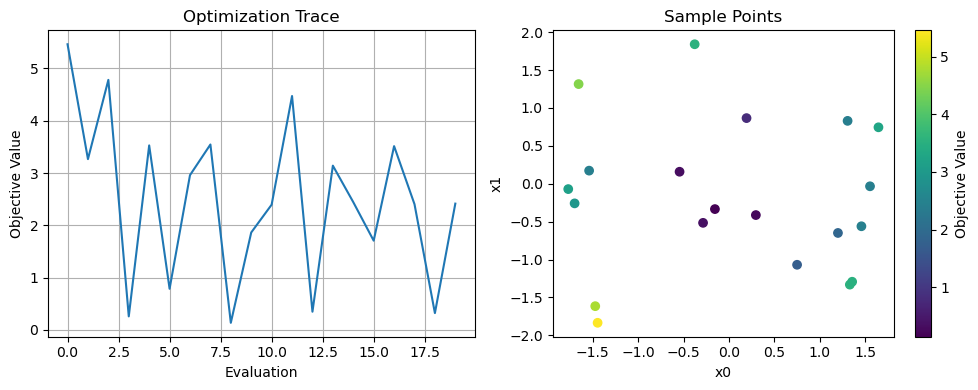

In [3]:
# Example 1: Maximum Evaluations Stopping Condition

# Create stopping condition that stops after 20 evaluations
max_evals_condition = MaxEvaluationsCondition(max_evaluations=20)

# Set up optimization with random generator
generator = RandomGenerator(vocs=sphere_vocs)
evaluator = Evaluator(function=sphere_function)

X = Xopt(
    vocs=sphere_vocs,
    generator=generator,
    evaluator=evaluator,
    stopping_condition=max_evals_condition,
)

# Run optimization - should stop automatically after 20 evaluations
X.run()

print(f"Optimization stopped after {len(X.data)} evaluations")
print(f"Best result: {X.data['f'].min():.6f}")

# Show the optimization trace
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(X.data["f"].values)
plt.xlabel("Evaluation")
plt.ylabel("Objective Value")
plt.title("Optimization Trace")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(X.data["x0"], X.data["x1"], c=X.data["f"], cmap="viridis")
plt.xlabel("x0")
plt.ylabel("x1")
plt.title("Sample Points")
plt.colorbar(label="Objective Value")
plt.tight_layout()
plt.show()

## 2. TargetValueCondition

Stop when an objective reaches a target value within a specified tolerance. Useful when you know what "good enough" looks like.

Optimization stopped after 8 evaluations
Target value: 0.1
Best result: 0.002116
Target achieved: True


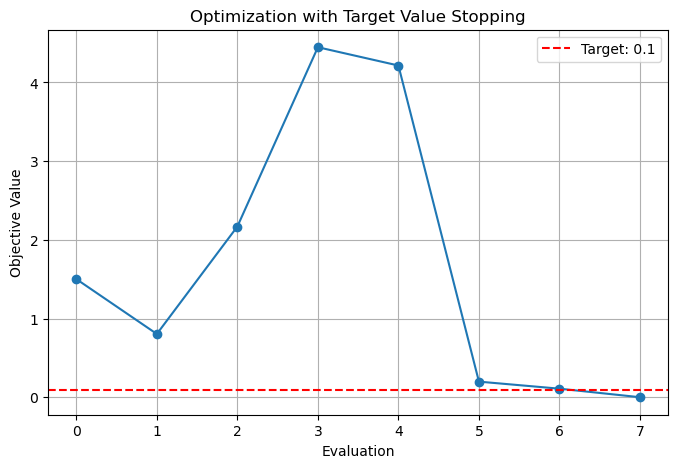

In [4]:
# Example 2: Target Value Stopping Condition

# Create condition to stop when objective reaches 0.1 or lower
target_condition = TargetValueCondition(
    objective_name="f", target_value=0.1, tolerance=1e-6
)

# Use Bayesian optimization for more efficient search
generator = UpperConfidenceBoundGenerator(vocs=sphere_vocs)

X = Xopt(
    vocs=sphere_vocs,
    generator=generator,
    evaluator=evaluator,
    stopping_condition=target_condition,
)

# Add some random initial points
X.random_evaluate(3)

# Run optimization until target is reached
X.run()

print(f"Optimization stopped after {len(X.data)} evaluations")
print(f"Target value: {target_condition.target_value}")
print(f"Best result: {X.data['f'].min():.6f}")
print(f"Target achieved: {X.data['f'].min() <= target_condition.target_value}")

# Plot the convergence
plt.figure(figsize=(8, 5))
plt.plot(X.data["f"].values, "o-")
plt.axhline(
    y=target_condition.target_value,
    color="r",
    linestyle="--",
    label=f"Target: {target_condition.target_value}",
)
plt.xlabel("Evaluation")
plt.ylabel("Objective Value")
plt.title("Optimization with Target Value Stopping")
plt.legend()
plt.grid(True)
plt.show()

## 3. ConvergenceCondition

Stop when the rate of improvement drops below a threshold. This detects when the optimization is converging and further evaluations are unlikely to yield significant improvements.

Optimization stopped after 12 evaluations
Improvement threshold: 0.01
Patience: 5
Final best result: -0.187115
Improvement over last 5 evaluations: -0.066026


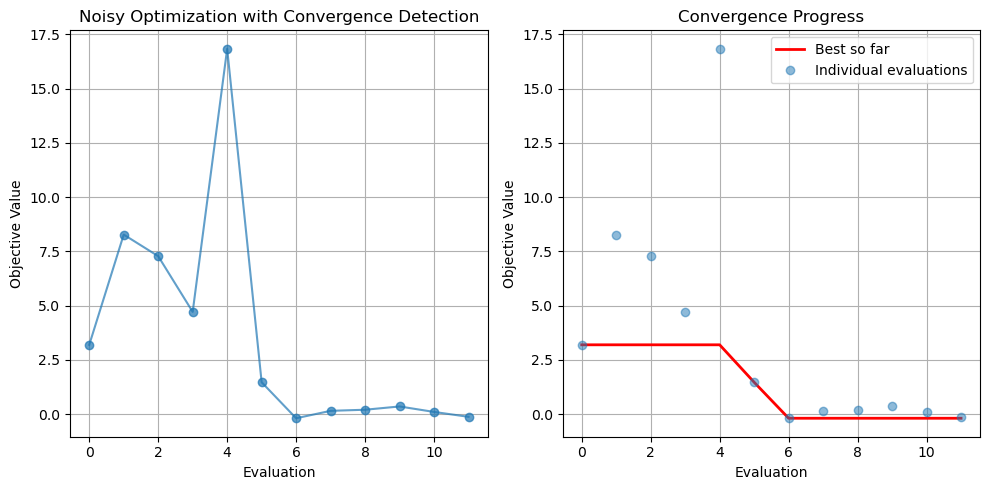

In [5]:
# Example 3: Convergence Stopping Condition

# Create condition to stop when improvement is less than 0.01 over 5 evaluations
convergence_condition = ConvergenceCondition(
    objective_name="f",
    improvement_threshold=0.01,
    patience=5,
    relative=False,  # Use absolute improvement
)

# Use the noisy function to make convergence detection more realistic
noisy_evaluator = Evaluator(function=noisy_quadratic)
generator = UpperConfidenceBoundGenerator(vocs=noisy_vocs)

X = Xopt(
    vocs=noisy_vocs,
    generator=generator,
    evaluator=noisy_evaluator,
    stopping_condition=convergence_condition,
)

# Start with some random points
X.random_evaluate(5)

# Run optimization until convergence detected
X.run()

print(f"Optimization stopped after {len(X.data)} evaluations")
print(f"Improvement threshold: {convergence_condition.improvement_threshold}")
print(f"Patience: {convergence_condition.patience}")
print(f"Final best result: {X.data['f'].min():.6f}")

# Analyze the convergence
last_values = X.data["f"].iloc[-6:].values  # Last 6 values
improvement = last_values[0] - last_values[-1]
print(
    f"Improvement over last {convergence_condition.patience} evaluations: {improvement:.6f}"
)

# Plot convergence behavior
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(X.data["f"].values, "o-", alpha=0.7)
plt.xlabel("Evaluation")
plt.ylabel("Objective Value")
plt.title("Noisy Optimization with Convergence Detection")
plt.grid(True)

# Show rolling minimum to see actual progress
plt.subplot(1, 2, 2)
rolling_min = X.data["f"].cummin()
plt.plot(rolling_min.values, "r-", linewidth=2, label="Best so far")
plt.plot(X.data["f"].values, "o", alpha=0.5, label="Individual evaluations")
plt.xlabel("Evaluation")
plt.ylabel("Objective Value")
plt.title("Convergence Progress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. StagnationCondition

Stop when the best objective value hasn't improved for a specified number of evaluations. This is similar to convergence but focuses specifically on the best value found.

Optimization stopped after 20 evaluations
Stagnation patience: 8
Tolerance: 0.001
Final best value: 0.000052
Best value 8 evaluations ago: 0.000821
Improvement over stagnation window: 0.000769


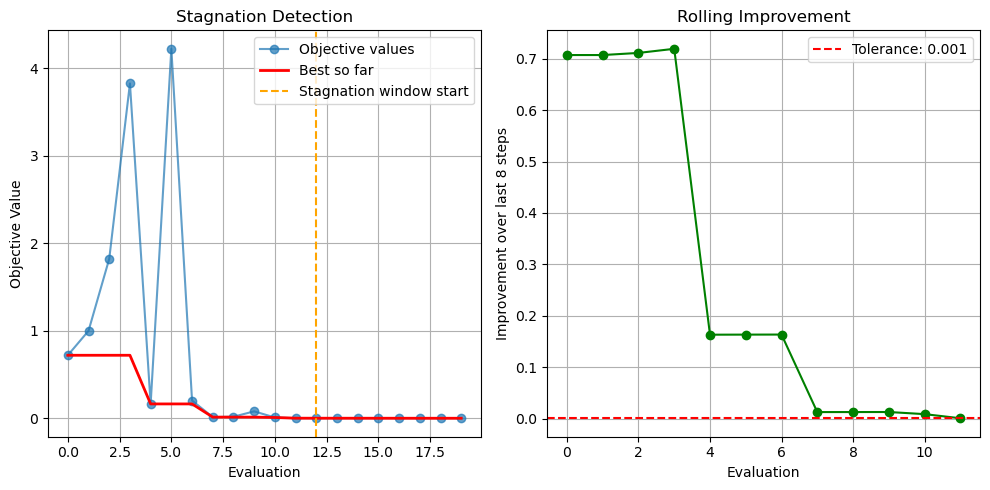

In [6]:
# Example 4: Stagnation Stopping Condition

# Stop if best value doesn't improve by at least 0.001 for 8 evaluations
stagnation_condition = StagnationCondition(
    objective_name="f", patience=8, tolerance=0.001
)

generator = UpperConfidenceBoundGenerator(vocs=sphere_vocs)

X = Xopt(
    vocs=sphere_vocs,
    generator=generator,
    evaluator=evaluator,
    stopping_condition=stagnation_condition,
)

# Start with initial points
X.random_evaluate(3)

# Run until stagnation detected
X.run()

print(f"Optimization stopped after {len(X.data)} evaluations")
print(f"Stagnation patience: {stagnation_condition.patience}")
print(f"Tolerance: {stagnation_condition.tolerance}")

# Analyze stagnation
cumulative_best = X.data["f"].cummin()
print(f"Final best value: {cumulative_best.iloc[-1]:.6f}")
print(
    f"Best value {stagnation_condition.patience} evaluations ago: {cumulative_best.iloc[-(stagnation_condition.patience + 1)]:.6f}"
)
improvement = (
    cumulative_best.iloc[-(stagnation_condition.patience + 1)]
    - cumulative_best.iloc[-1]
)
print(f"Improvement over stagnation window: {improvement:.6f}")

# Visualize stagnation detection
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(X.data["f"].values, "o-", alpha=0.7, label="Objective values")
plt.plot(cumulative_best.values, "r-", linewidth=2, label="Best so far")
plt.axvline(
    x=len(X.data) - stagnation_condition.patience,
    color="orange",
    linestyle="--",
    label="Stagnation window start",
)
plt.xlabel("Evaluation")
plt.ylabel("Objective Value")
plt.title("Stagnation Detection")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# Show improvement over rolling windows
improvements = []
for i in range(stagnation_condition.patience, len(cumulative_best)):
    imp = (
        cumulative_best.iloc[i - stagnation_condition.patience]
        - cumulative_best.iloc[i]
    )
    improvements.append(imp)

plt.plot(improvements, "g-", marker="o")
plt.axhline(
    y=stagnation_condition.tolerance,
    color="r",
    linestyle="--",
    label=f"Tolerance: {stagnation_condition.tolerance}",
)
plt.xlabel("Evaluation")
plt.ylabel(f"Improvement over last {stagnation_condition.patience} steps")
plt.title("Rolling Improvement")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. FeasibilityCondition

Stop when a feasible solution is found. This is useful for constraint satisfaction problems where finding any feasible solution is the primary goal.

Optimization stopped after 3 evaluations
Number of feasible solutions found: 1
First feasible solution:
  x1 = 0.1474, x2 = 1.3211
  Objective = 0.7986
  c1 = 1.5171 (should be >= 0)
  c2 = 0.0315 (should be >= 0)


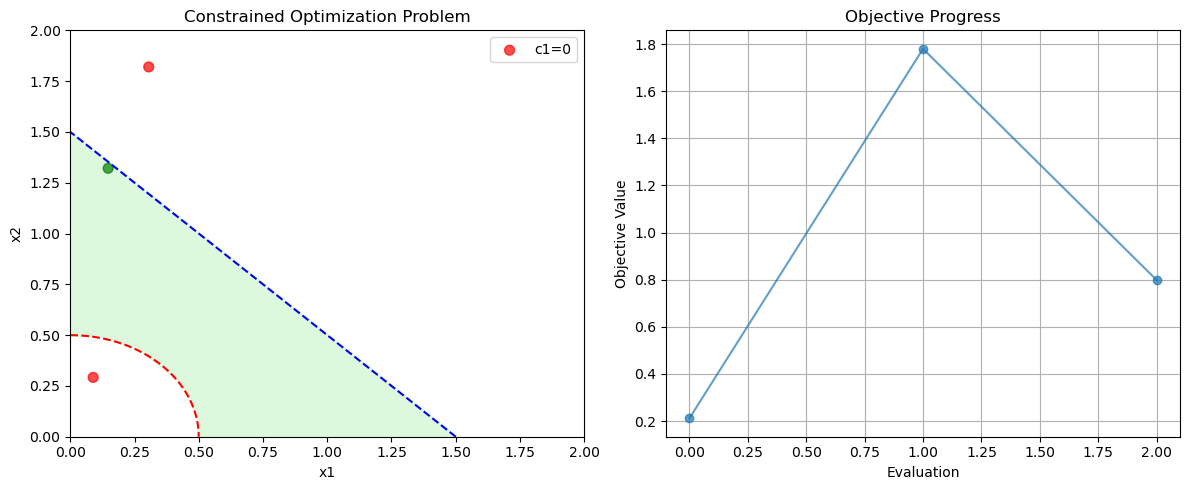

In [7]:
# Example 5: Feasibility Stopping Condition

# Stop when a fully feasible solution is found
feasibility_condition = FeasibilityCondition(
    require_all_constraints=True  # All constraints must be satisfied
)

# Use constrained function and VOCS
constrained_evaluator = Evaluator(function=constrained_function)
generator = RandomGenerator(vocs=constrained_vocs)

X = Xopt(
    vocs=constrained_vocs,
    generator=generator,
    evaluator=constrained_evaluator,
    stopping_condition=feasibility_condition,
)

# Run until feasible solution found
X.run()

print(f"Optimization stopped after {len(X.data)} evaluations")

# Check feasibility of final solutions
feasibility_data = constrained_vocs.feasibility_data(X.data)
print(f"Number of feasible solutions found: {feasibility_data['feasible'].sum()}")

if feasibility_data["feasible"].any():
    feasible_idx = feasibility_data["feasible"].idxmax()
    feasible_point = X.data.loc[feasible_idx]
    print("First feasible solution:")
    print(f"  x1 = {feasible_point['x1']:.4f}, x2 = {feasible_point['x2']:.4f}")
    print(f"  Objective = {feasible_point['f']:.4f}")
    print(f"  c1 = {feasible_point['c1']:.4f} (should be >= 0)")
    print(f"  c2 = {feasible_point['c2']:.4f} (should be >= 0)")

# Visualize the constrained optimization problem
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Plot constraint regions
x1_range = np.linspace(0, 2, 100)
x2_range = np.linspace(0, 2, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

# c1: x1^2 + x2^2 >= 0.25 (feasible outside circle)
C1 = X1**2 + X2**2 - 0.25
# c2: x1 + x2 <= 1.5 (feasible below line)
C2 = 1.5 - (X1 + X2)

# Feasible region
feasible_region = (C1 >= 0) & (C2 >= 0)
plt.contour(X1, X2, C1, levels=[0], colors=["red"], linestyles=["--"])
plt.contour(X1, X2, C2, levels=[0], colors=["blue"], linestyles=["--"])
plt.contourf(
    X1, X2, feasible_region, levels=[0.5, 1.5], colors=["lightgreen"], alpha=0.3
)

# Plot sample points
colors = ["red" if not f else "green" for f in feasibility_data["feasible"]]
plt.scatter(X.data["x1"], X.data["x2"], c=colors, alpha=0.7, s=50)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Constrained Optimization Problem")
plt.legend(
    ["c1=0", "c2=0", "Feasible region", "Infeasible", "Feasible"], loc="upper right"
)

plt.subplot(1, 2, 2)
plt.plot(X.data["f"].values, "o-", alpha=0.7)
plt.xlabel("Evaluation")
plt.ylabel("Objective Value")
plt.title("Objective Progress")
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. CompositeCondition

Combine multiple stopping conditions with AND/OR logic. This allows for sophisticated stopping criteria that consider multiple factors simultaneously.

=== Composite OR Condition Results ===
Optimization stopped after 3 evaluations
Best result: 0.011075
Max evaluations condition (>=50): False
Target value condition (<=0.02): True


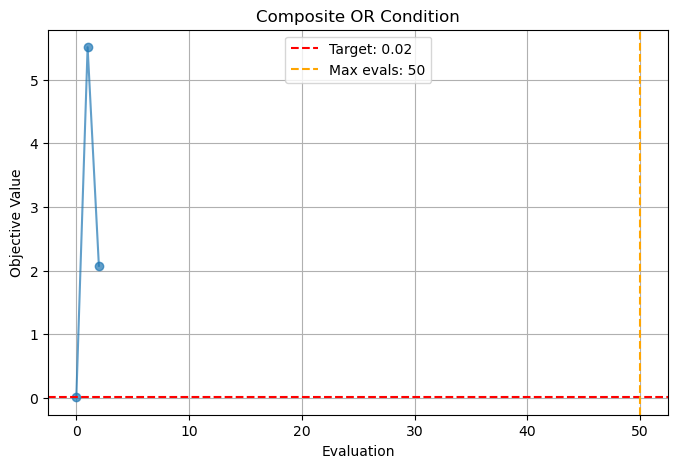

In [8]:
# Example 6A: Composite Condition with OR logic
# Stop if EITHER max evaluations is reached OR target value is achieved

composite_or_condition = CompositeCondition(
    conditions=[
        MaxEvaluationsCondition(max_evaluations=50),
        TargetValueCondition(objective_name="f", target_value=0.02, tolerance=1e-6),
    ],
    logic="or",  # Stop if ANY condition is met
)

generator = UpperConfidenceBoundGenerator(vocs=sphere_vocs)

X = Xopt(
    vocs=sphere_vocs,
    generator=generator,
    evaluator=evaluator,
    stopping_condition=composite_or_condition,
)

X.random_evaluate(3)
X.run()

print("=== Composite OR Condition Results ===")
print(f"Optimization stopped after {len(X.data)} evaluations")
print(f"Best result: {X.data['f'].min():.6f}")

# Check which conditions were satisfied
max_evals_satisfied = len(X.data) >= 50
target_satisfied = X.data["f"].min() <= 0.02
print(f"Max evaluations condition (>=50): {max_evals_satisfied}")
print(f"Target value condition (<=0.02): {target_satisfied}")

plt.figure(figsize=(8, 5))
plt.plot(X.data["f"].values, "o-", alpha=0.7)
plt.axhline(y=0.02, color="r", linestyle="--", label="Target: 0.02")
plt.axvline(x=50, color="orange", linestyle="--", label="Max evals: 50")
plt.xlabel("Evaluation")
plt.ylabel("Objective Value")
plt.title("Composite OR Condition")
plt.legend()
plt.grid(True)
plt.show()

=== Composite AND Condition Results ===
Optimization stopped after 25 evaluations
Best result: 0.000477
Max evaluations condition (>=25): True
Stagnation condition: True
Both conditions required for AND logic


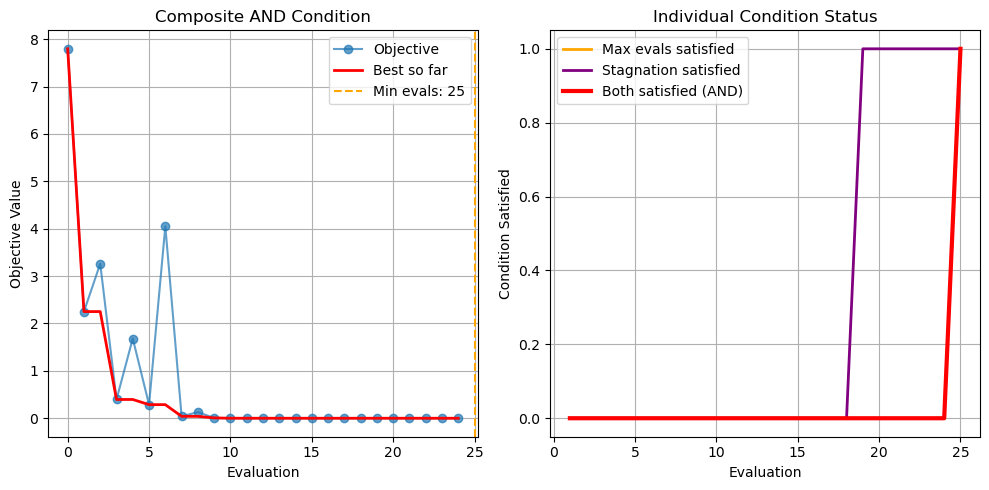

In [9]:
# Example 6B: Composite Condition with AND logic
# Stop only when BOTH max evaluations AND stagnation are detected

composite_and_condition = CompositeCondition(
    conditions=[
        MaxEvaluationsCondition(max_evaluations=25),  # Must reach at least 25 evals
        StagnationCondition(objective_name="f", patience=8, tolerance=0.001),
    ],
    logic="and",  # Stop only if ALL conditions are met
)

generator = UpperConfidenceBoundGenerator(vocs=sphere_vocs)

X = Xopt(
    vocs=sphere_vocs,
    generator=generator,
    evaluator=evaluator,
    stopping_condition=composite_and_condition,
)

X.random_evaluate(3)
X.run()

print("=== Composite AND Condition Results ===")
print(f"Optimization stopped after {len(X.data)} evaluations")
print(f"Best result: {X.data['f'].min():.6f}")

# Check which conditions were satisfied
max_evals_satisfied = len(X.data) >= 25
# For stagnation, check last few points
if len(X.data) >= 9:
    cumulative_best = X.data["f"].cummin()
    last_improvement = cumulative_best.iloc[-9] - cumulative_best.iloc[-1]
    stagnation_satisfied = last_improvement < 0.001
else:
    stagnation_satisfied = False

print(f"Max evaluations condition (>=25): {max_evals_satisfied}")
print(f"Stagnation condition: {stagnation_satisfied}")
print("Both conditions required for AND logic")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(X.data["f"].values, "o-", alpha=0.7, label="Objective")
cumulative_best = X.data["f"].cummin()
plt.plot(cumulative_best.values, "r-", linewidth=2, label="Best so far")
plt.axvline(x=25, color="orange", linestyle="--", label="Min evals: 25")
plt.xlabel("Evaluation")
plt.ylabel("Objective Value")
plt.title("Composite AND Condition")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# Show when both conditions would be satisfied individually
x_vals = list(range(1, len(X.data) + 1))
max_eval_status = [x >= 25 for x in x_vals]
stag_status = [False] * len(x_vals)
for i in range(8, len(x_vals)):
    improvement = cumulative_best.iloc[i - 8] - cumulative_best.iloc[i]
    stag_status[i] = improvement < 0.001

plt.plot(x_vals, max_eval_status, "orange", linewidth=2, label="Max evals satisfied")
plt.plot(x_vals, stag_status, "purple", linewidth=2, label="Stagnation satisfied")
and_status = [m and s for m, s in zip(max_eval_status, stag_status)]
plt.plot(x_vals, and_status, "red", linewidth=3, label="Both satisfied (AND)")
plt.xlabel("Evaluation")
plt.ylabel("Condition Satisfied")
plt.title("Individual Condition Status")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Creating Stopping Conditions from Configuration

Stopping conditions can also be created from dictionaries or YAML configurations for easy integration with automated workflows.

In [10]:
# Example 7: Creating stopping conditions from configuration

# Define a complex stopping condition using dictionary configuration
stopping_config = {
    "name": "CompositeCondition",
    "conditions": [
        {"name": "MaxEvaluationsCondition", "max_evaluations": 100},
        {
            "name": "CompositeCondition",
            "logic": "and",
            "conditions": [
                {
                    "name": "TargetValueCondition",
                    "objective_name": "f",
                    "target_value": 0.01,
                    "tolerance": 1e-6,
                },
                {
                    "name": "ConvergenceCondition",
                    "objective_name": "f",
                    "improvement_threshold": 0.005,
                    "patience": 5,
                    "relative": False,
                },
            ],
        },
    ],
    "logic": "or",
}

# Create the condition from the configuration

condition_class = get_stopping_condition(stopping_config["name"])
configured_condition = condition_class(
    **{k: v for k, v in stopping_config.items() if k != "name"}
)

print("Successfully created stopping condition from configuration:")
print(f"Type: {type(configured_condition).__name__}")
print(f"Logic: {configured_condition.logic}")
print(f"Number of sub-conditions: {len(configured_condition.conditions)}")

# Test the configured condition
generator = UpperConfidenceBoundGenerator(vocs=sphere_vocs)

X = Xopt(
    vocs=sphere_vocs,
    generator=generator,
    evaluator=evaluator,
    stopping_condition=configured_condition,
)

X.random_evaluate(3)
X.run()

print(
    f"\nOptimization with configured condition stopped after {len(X.data)} evaluations"
)
print(f"Best result: {X.data['f'].min():.6f}")

# The condition stops if:
# 1. Max evaluations (100) reached, OR
# 2. Target value (0.01) achieved AND convergence detected

target_reached = X.data["f"].min() <= 0.01
print(f"Target value (0.01) reached: {target_reached}")
print(f"Max evaluations reached: {len(X.data) >= 100}")

Successfully created stopping condition from configuration:
Type: CompositeCondition
Logic: or
Number of sub-conditions: 2



Optimization with configured condition stopped after 12 evaluations
Best result: 0.006974
Target value (0.01) reached: True
Max evaluations reached: False


## Summary and Best Practices

### Stopping Condition Types Summary

1. **MaxEvaluationsCondition**: Simple budget control
2. **TargetValueCondition**: Stop when goal is reached  
3. **ConvergenceCondition**: Detect when improvement rate slows
4. **StagnationCondition**: Detect when best value stops improving
5. **FeasibilityCondition**: Stop when constraints are satisfied
6. **CompositeCondition**: Combine multiple conditions with logic

### Best Practices

- **Always use some form of maximum evaluation limit** to prevent runaway optimizations
- **Combine conditions with OR logic** for robustness (e.g., max evals OR convergence)  
- **Use target values when you know the goal** (e.g., engineering requirements)
- **Use convergence/stagnation for black-box problems** where the optimum is unknown
- **Monitor feasibility in constrained problems** to find solutions quickly
- **Tune patience and thresholds** based on your problem's noise level and evaluation cost
- **Test stopping conditions** on simpler problems first to validate behavior
